In [2]:
# Methods

import matplotlib.image as mpimg
import numpy as np
import cv2, time, glob, time
from random import shuffle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from numpy.random import randint
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    if spatial_feat:
        print('Spatial features:', len(spatial_features))
    if hist_feat:
        print('Hist features:', len(hist_features))
    if hog_feat:    
        print('Hog features:', len(hog_features))
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(randint(0,255), randint(0,255), randint(0,255)), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def read_csv_dataset(csv_file_path, sample_from_row_cols):
        f = open(csv_file_path, "r")
        rows = f.read().split("\n")
        samples = []
        for row in rows:
            cols = row.split(" ")
            if len(cols) > 1:
                sample = sample_from_row_cols(cols)
                samples.append(sample)
        
        vehicles = [sample for sample in samples if 'car' in sample or 'truck' in sample]
        non_vehicles = [sample for sample in samples if not ('car' in sample or 'truck' in sample)]
        
        return vehicles, non_vehicles
    
def train_classifier(vehicles, non_vehicles, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, 
                     hog_channel = 0, spatial_size=(32, 32), hist_bins=32, 
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    
    print('Vehicles:', len(vehicles))
    print('Non vehicles:', len(non_vehicles))
    
#     # Read Udacity Annotated Driving Dataset One
#     sample_from_row_cols = lambda cols: [cols[0], ((int(cols[1]), int(cols[2])), (int(cols[3]), int(cols[4]))), cols[6][1:-1]]
#     vehicles, non_vehicles = read_csv_dataset('udacity-annotated-driving-dataset-one/labels.csv', sample_from_row_cols)

#     Reduce the sample size because
#     The quiz evaluator times out after 13s of CPU time
#     sample_size = 2000
#     vehicles = vehicles[0:sample_size]
#     non_vehicles = non_vehicles[0:sample_size]

    car_features = extract_features(vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    notcar_features = extract_features(non_vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 6))
    # Check the prediction time for a single sample
    t=time.time()
    
    return svc, X_scaler
    
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel = 0,
              spatial_size=(32, 32), hist_bins=32, spatial_feat=True, hist_feat=True, hog_feat=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = np.copy(img_tosearch)
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            if spatial_feat and hist_feat:
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)      
            else:
                X = np.hstack((hog_features)).reshape(1, -1)

            # Scale features and make a prediction
            test_features = X_scaler.transform(X)    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (randint(0,255), randint(0,255), randint(0,255)),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bboxes

def heat_map_bboxes_image(image, bboxes, threshold):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    def add_heat(heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 200), 6)
        # Return the image
        return img

    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img, heatmap, labels

In [3]:
# Read dataset

vehicles = glob.glob('project-dataset/vehicles/*/*.png')
non_vehicles = glob.glob('project-dataset/non-vehicles/*/*.png')

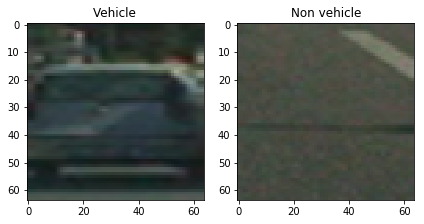

In [4]:
# Show vehicle and non vehicle images

vehicle = mpimg.imread(vehicles[randint(0, len(vehicles))])    
non_vehicle = mpimg.imread(non_vehicles[randint(0, len(non_vehicles))])

fig = plt.figure()
plt.subplot(121)
plt.imshow(vehicle)
plt.title('Vehicle')
plt.subplot(122)
plt.imshow(non_vehicle)
plt.title('Non vehicle')
fig.tight_layout()

plt.savefig('output_images/car_not_car.png')
plt.show()

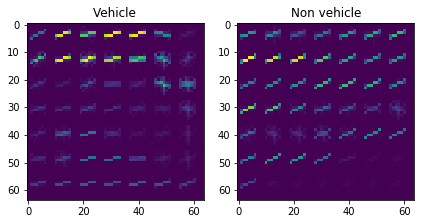

In [5]:
# Show HOG

def hog_img(img_tosearch):
    ctrans_tosearch = np.copy(img_tosearch)
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    imshape = ctrans_tosearch.shape

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    hog1, hog_img1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    hog2, hog_img2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    hog3, hog_img3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    
    return hog_img1

orient = 11  # HOG orientations
pix_per_cell = 9 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
color_space='YCrCb' 

vehicle = mpimg.imread(vehicles[randint(0, len(vehicles))])    
non_vehicle = mpimg.imread(non_vehicles[randint(0, len(non_vehicles))])

def plt_hog_images():
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(hog_img(vehicle))
    plt.title('Vehicle')
    plt.subplot(122)
    plt.imshow(hog_img(non_vehicle))
    plt.title('Non vehicle')
    fig.tight_layout()
    
    plt.savefig('output_images/hog_example.png')
    plt.show()  

plt_hog_images()

In [6]:
# Parameters

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 9 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 256    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [7]:
# Train classifier

vehicles = glob.glob('project-dataset/vehicles/*/*.png')
non_vehicles = glob.glob('project-dataset/non-vehicles/*/*.png')
    
svc, X_scaler = train_classifier(vehicles, non_vehicles, 
                                 color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

Vehicles: 8792
Non vehicles: 8968
Spatial features: 3072
Hist features: 768
Hog features: 5184
Spatial features: 3072
Hist features: 768
Hog features: 5184
Using: 12 orientations 9 pixels per cell and 2 cells per block
Feature vector length: 9024
11.56 Seconds to train SVC...
Test Accuracy of SVC =  0.992117


In [8]:
# Train classifier for drawing all bboxes

non_vehicles = glob.glob('project-dataset/non-vehicles/*/*.png')
vehicles = glob.glob('project-dataset/vehicles/*/*0000*.png')
    
p_svc, p_X_scaler = train_classifier(non_vehicles, vehicles, 
                                 color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, 
                                 cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

Vehicles: 8968
Non vehicles: 3
Spatial features: 3072
Hist features: 768
Hog features: 5184
Spatial features: 3072
Hist features: 768
Hog features: 5184
Using: 12 orientations 9 pixels per cell and 2 cells per block
Feature vector length: 9024
122.12 Seconds to train SVC...
Test Accuracy of SVC =  0.999443


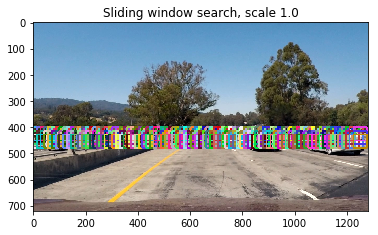

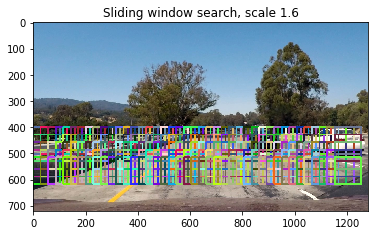

In [16]:
# Draw all bboxes

image = mpimg.imread('test_images/test1.jpg')

draw_img, bboxes = find_cars(image, 400, 500, 0.8, p_svc, p_X_scaler,
                                 color_space=color_space, orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block, hog_channel=hog_channel,
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

plt.imshow(draw_img)
plt.title('Sliding window search, scale 1.0')
plt.savefig('output_images/sliding_windows_1_0.png')
plt.show()

draw_img, bboxes = find_cars(image, 400, 656, 1.6, p_svc, p_X_scaler,
                                 color_space=color_space, orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block, hog_channel=hog_channel,
                                 spatial_size=spatial_size, hist_bins=hist_bins, 
                                 spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

plt.imshow(draw_img)
plt.title('Sliding window search, scale 1.6')
plt.savefig('output_imagesexamples/sliding_windows_1_6.png')
plt.show()

In [8]:
from moviepy.editor import VideoFileClip
import scipy.misc

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
        heatmap[heatmap <= threshold] = 0
        return heatmap

def draw_labeled_bboxes(img, labels):
    bboxes = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 200), 6)
        bboxes.append(bbox)
    return img, bboxes
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for frame_bboxes in frames_bboxes:
        heat = add_heat(heat, frame_bboxes)

    heat = apply_threshold(heat, frames_threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img, labeled_bboxes = draw_labeled_bboxes(np.copy(image), labels)    
    
    if visualize:
        plt.imshow(heatmap)
        plt.savefig('output_images/find_cars_heatmap.png')
        plt.show()

        plt.imshow(labels[0], cmap='gray')
        plt.savefig('output_images/find_cars_labels.png')
        plt.show()

        plt.imshow(draw_img)
        plt.savefig('output_imagesexamples/find_cars_labeled_bboxes.png')
        plt.show()
        
    return draw_img, heatmap, labeled_bboxes

# filenames = glob.glob("./project_video_images/image5??.*")
# images = [mpimg.imread(filename) for filename in filenames[:6]]
# process_frames(images)

In [9]:
def process_frame(image, scales, scales_threshold):
    # Predict bboxes on different scales
    scale_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for scale in scales:
        draw_img, bboxes = find_cars(image, 400, 656, scale, svc, X_scaler,
                                     color_space=color_space, orient=orient, pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block, hog_channel=hog_channel,
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        scale_heat = add_heat(scale_heat, bboxes)
    
    # Filter predictions on different scales
    scale_heat = apply_threshold(scale_heat, scales_threshold)
    scale_heatmap = np.clip(scale_heat, 0, 255)
    scale_labels = label(scale_heatmap)
    scale_draw_img, scale_labeled_bboxes = draw_labeled_bboxes(np.copy(image), scale_labels)
    
    return scale_heatmap, scale_draw_img, scale_labeled_bboxes

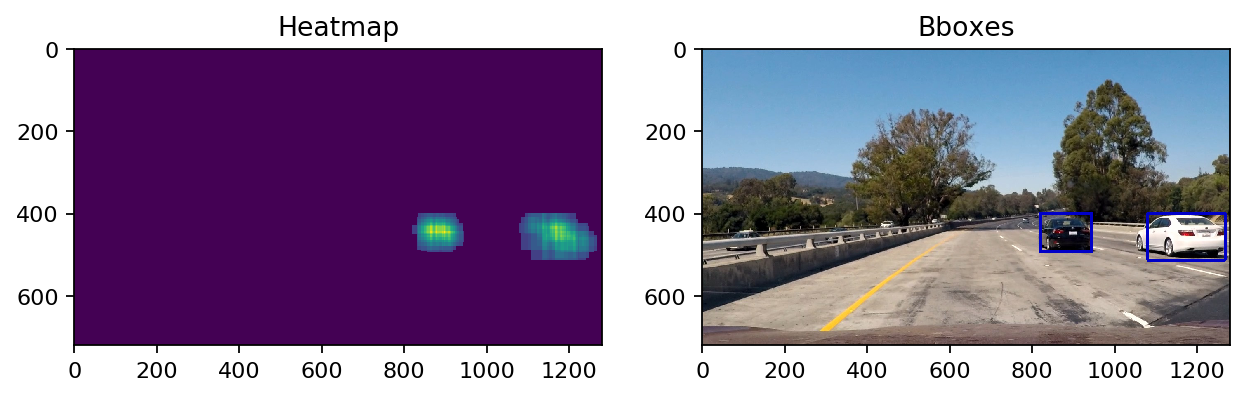

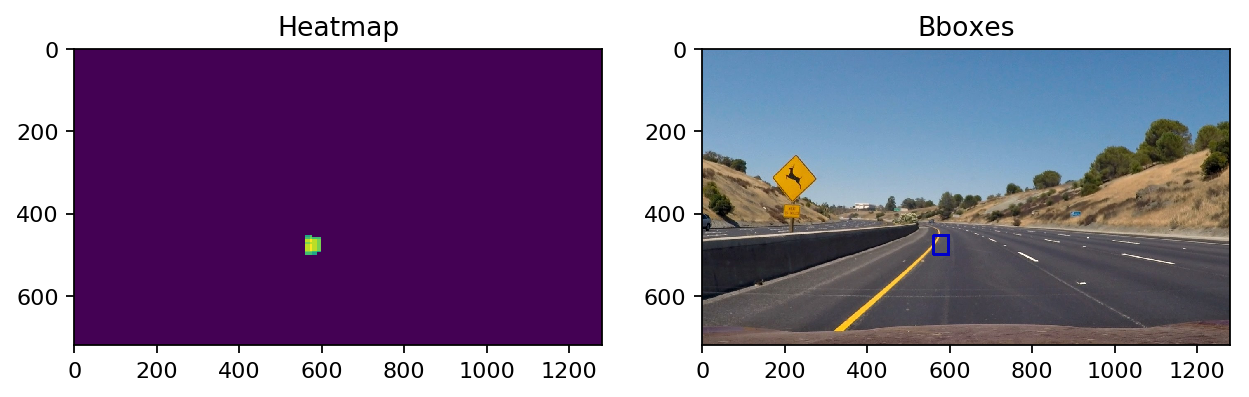

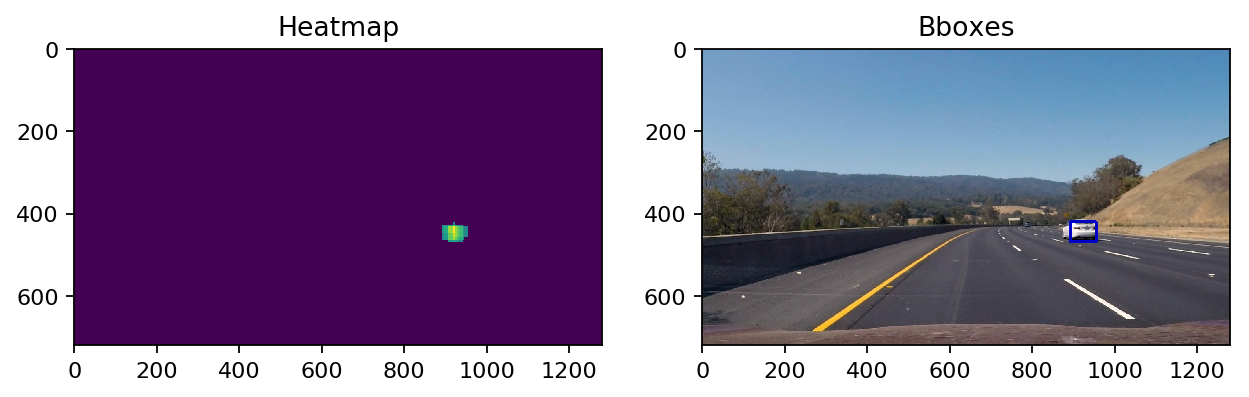

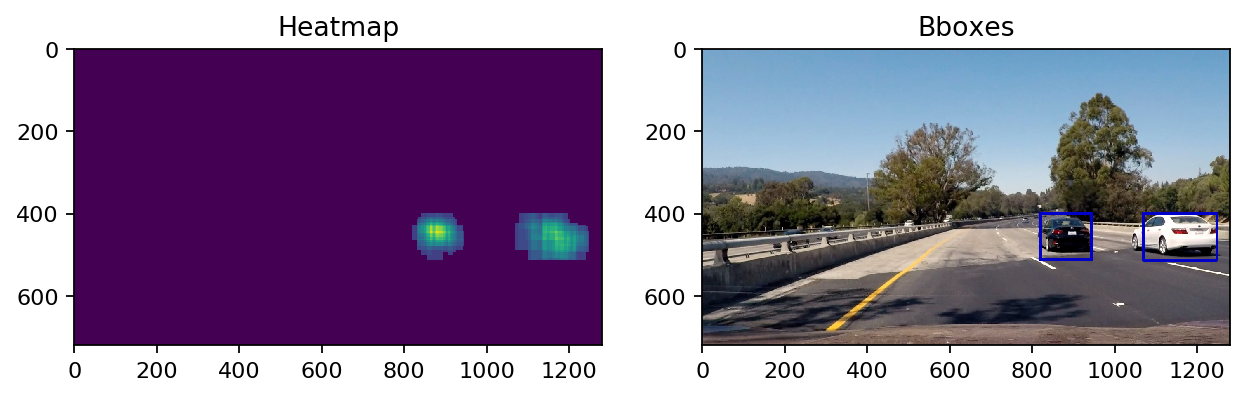

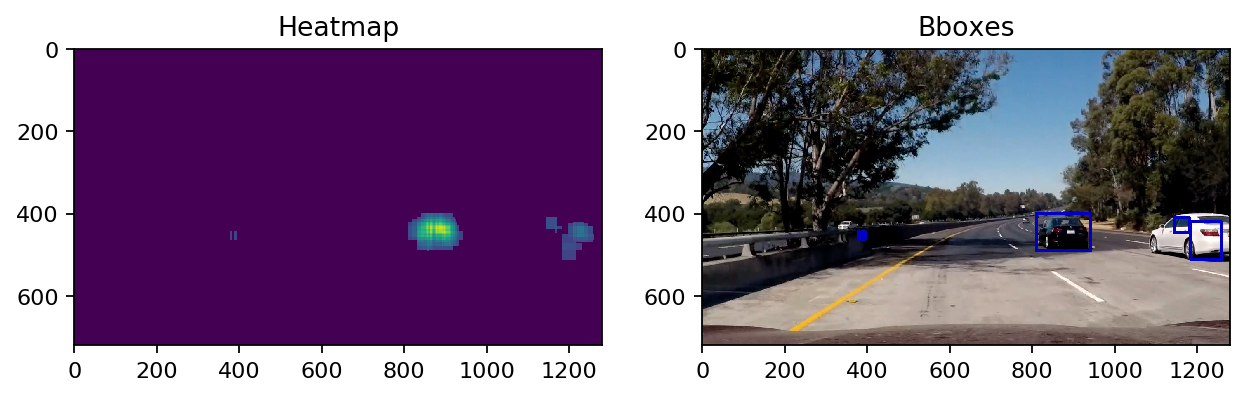

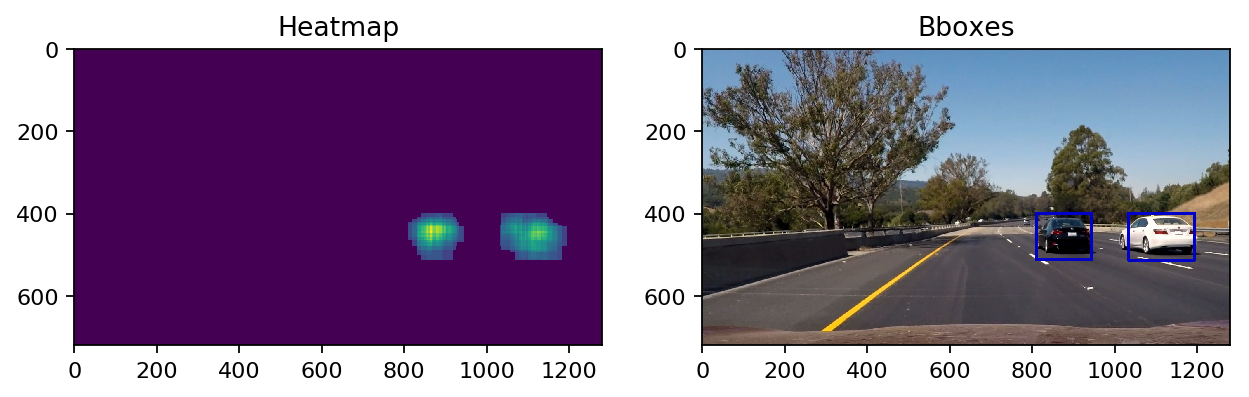

In [15]:
scales = [0.6, 0.8, 1.4, 1.8, 2.6]
scales_threshold = 5

# Process test images
filenames = glob.glob("./test_images/*.*")
for filename in filenames:
    image = mpimg.imread(filename)
    scales_heatmap, scales_image, scales_bboxes = process_frame(image, scales, scales_threshold)
    
    fig = plt.figure(num=None, figsize=(8, 6), dpi=160)
    plt.subplot(121)
    plt.imshow(scales_heatmap)
    plt.title('Heatmap')
    plt.subplot(122)
    plt.imshow(scales_image)
    plt.title('Bboxes')
    fig.tight_layout()
    plt.show()

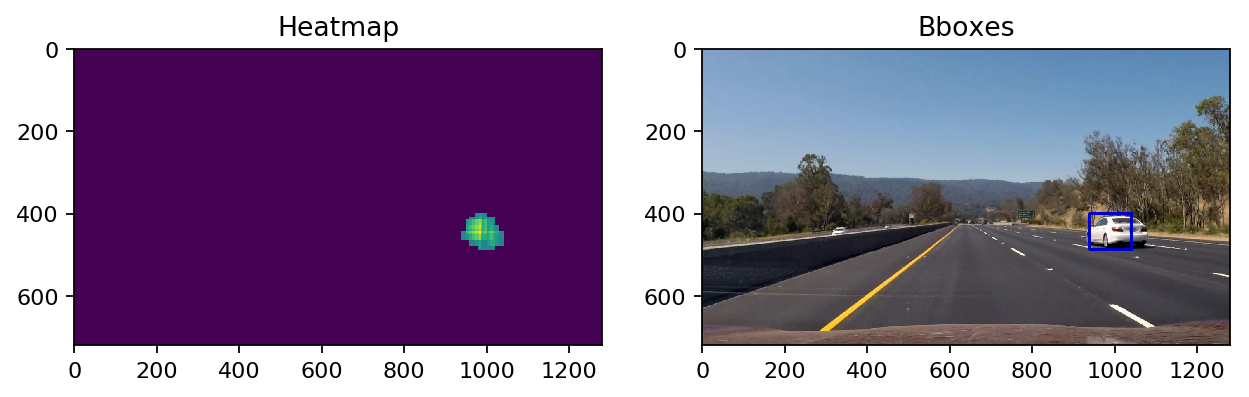

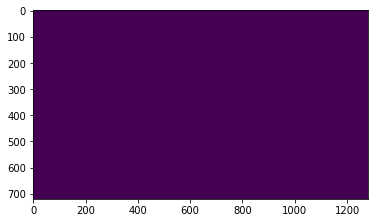

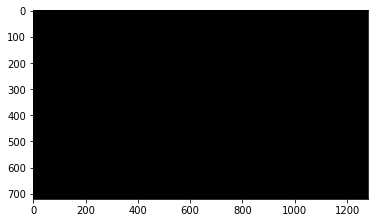

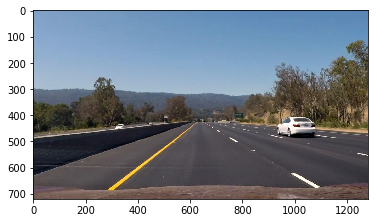

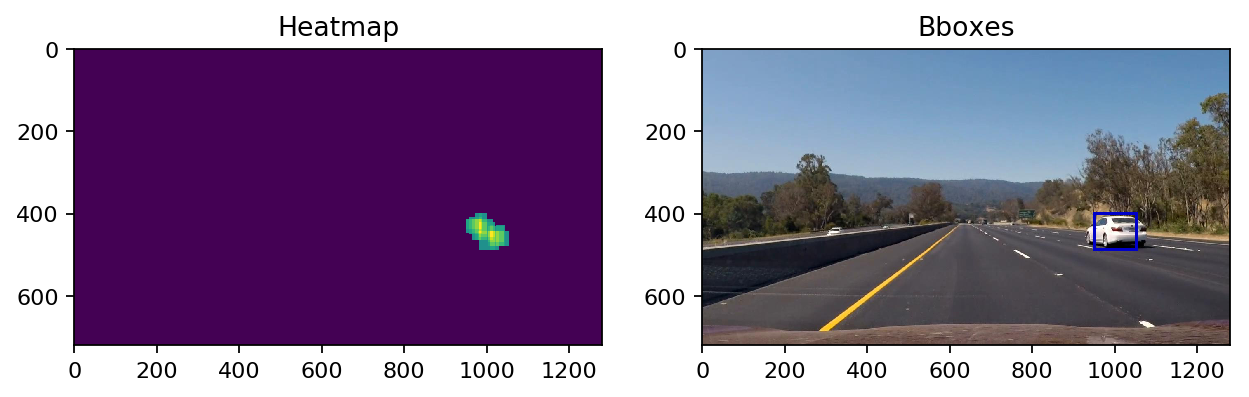

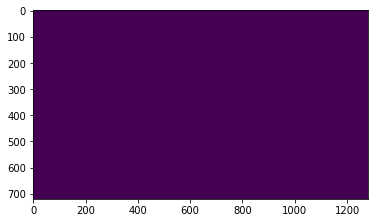

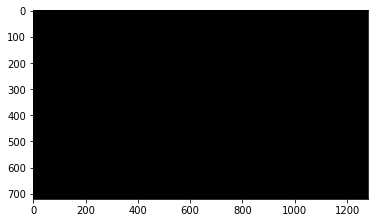

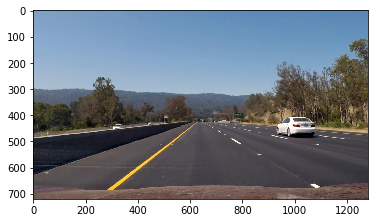

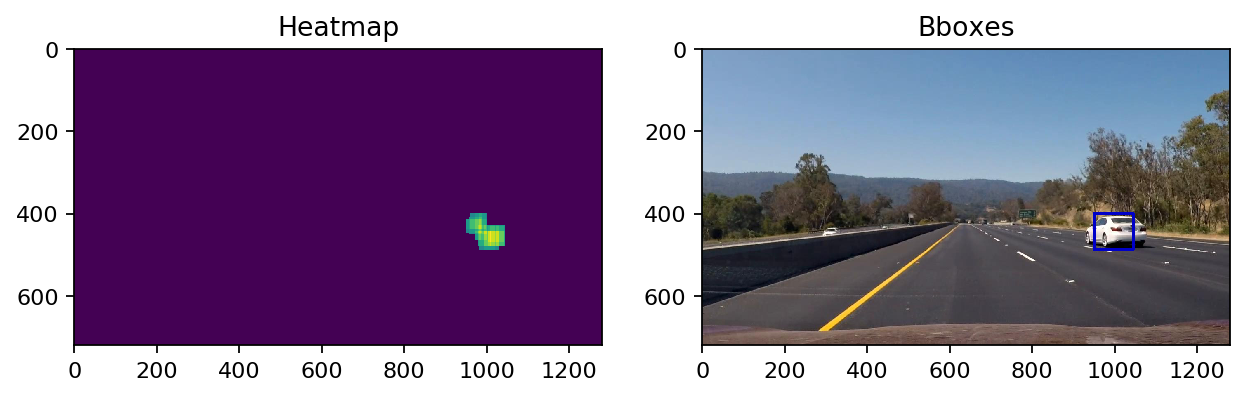

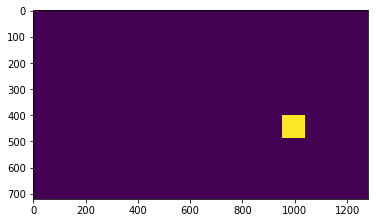

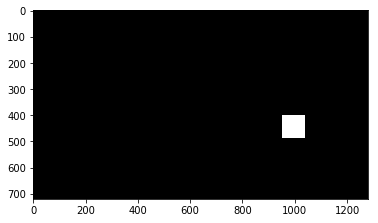

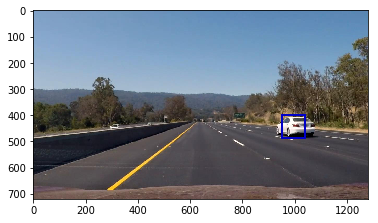

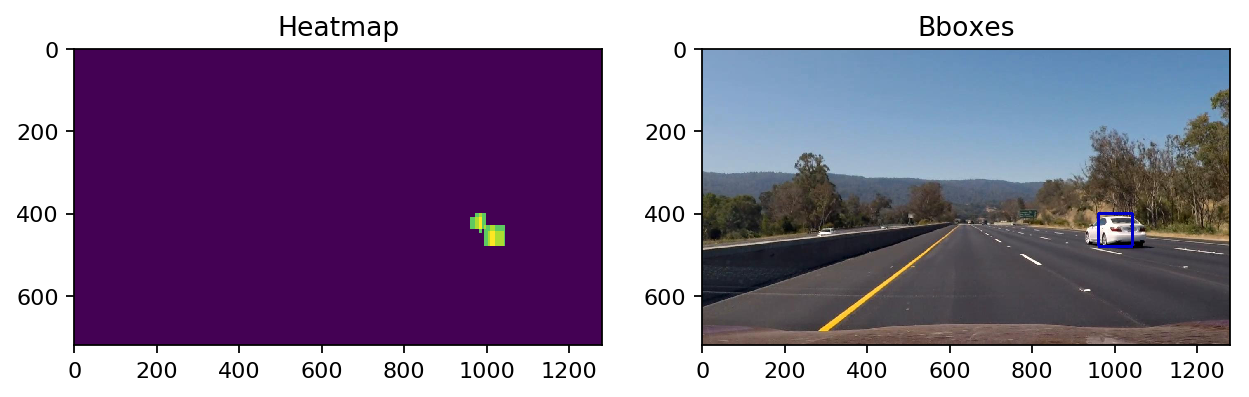

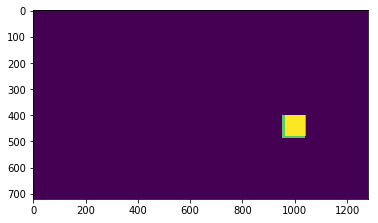

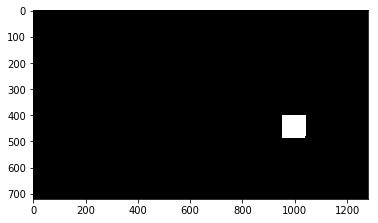

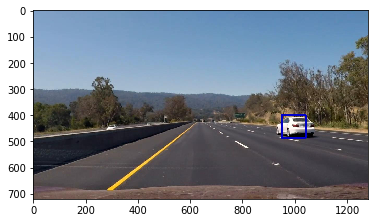

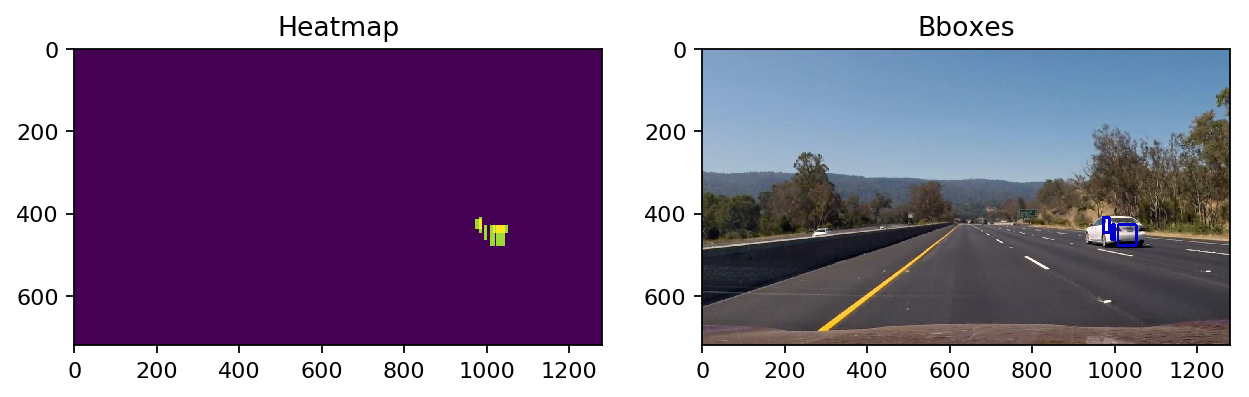

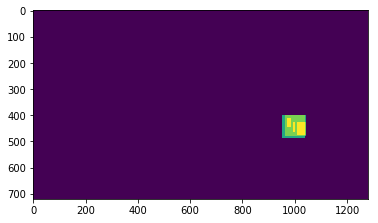

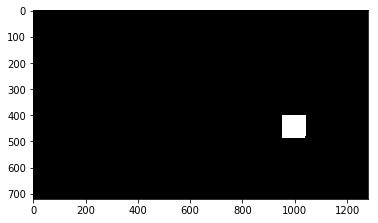

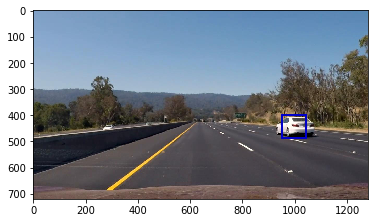

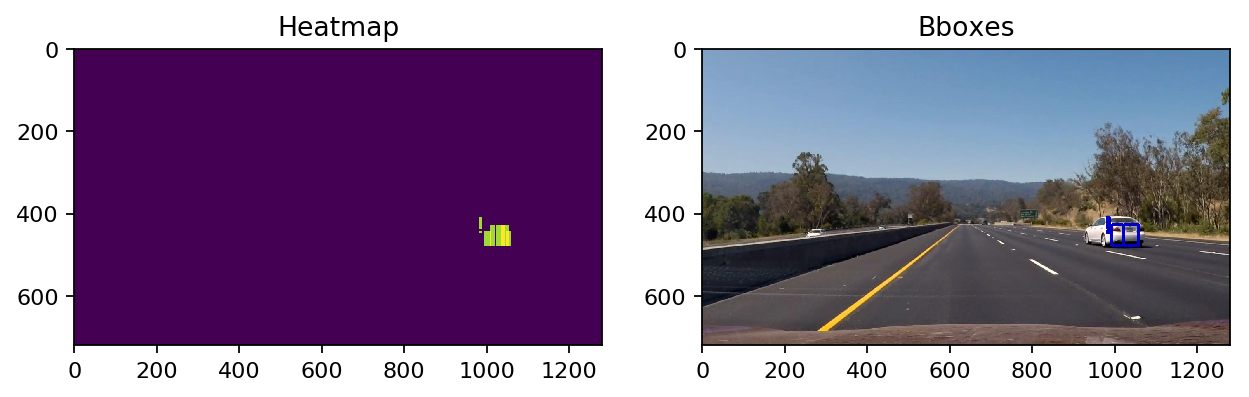

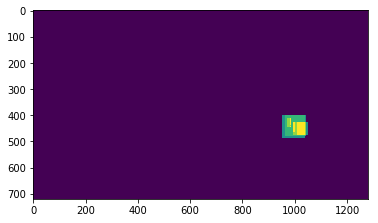

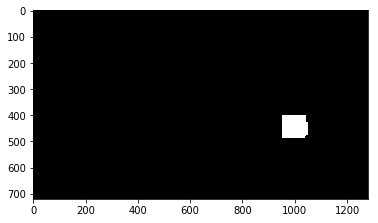

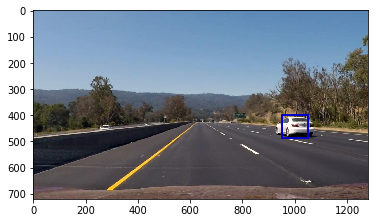

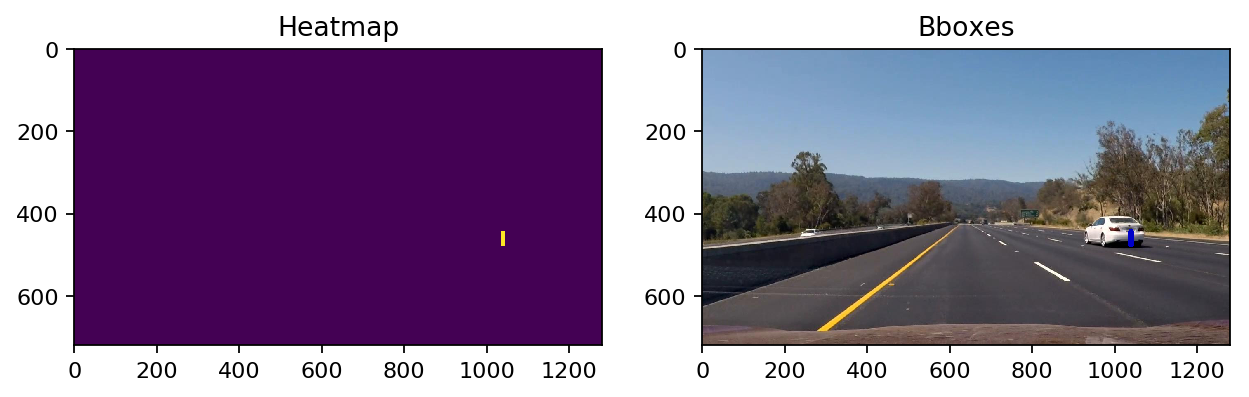

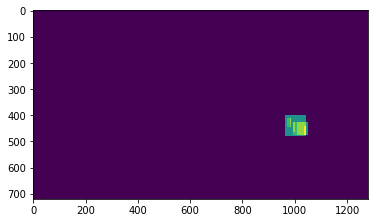

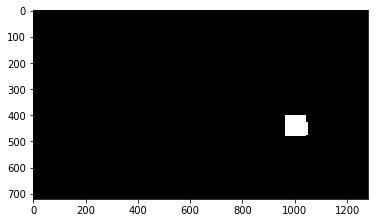

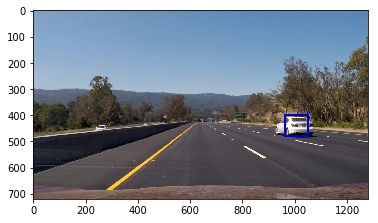

KeyboardInterrupt: 

In [16]:
frames_bboxes = []
frames_bboxes_count = 6
frames_threshold = 2

def process_image(image):
    global frames_bboxes
    
    # Search cars on different scales
    scales_heatmap, scales_image, scales_bboxes = process_frame(image, scales, scales_threshold)

    fig = plt.figure(num=None, figsize=(8, 6), dpi=160)
    plt.subplot(121)
    plt.imshow(scales_heatmap)
    plt.title('Heatmap')
    plt.subplot(122)
    plt.imshow(scales_image)
    plt.title('Bboxes')
    fig.tight_layout()
    plt.show()
    
    # Append predictions to series of frames
    frames_bboxes.append(scales_bboxes)
    
    # Keep frames count the same
    if len(frames_bboxes) == frames_bboxes_count + 1:
        frames_bboxes.pop(0)
    
    # Build heatmap with series of frame bboxes
    draw_img, heatmap, bboxes = process_frames_bboxes(frames_bboxes, frames_threshold, image, visualize=False)
    
    fig = plt.figure(num=None, figsize=(8, 6), dpi=160)
    plt.subplot(121)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.subplot(122)
    plt.imshow(draw_img)
    plt.title('Bboxes')
    fig.tight_layout()
    plt.show()
    
    return draw_img
    
test_video_filename = 'test_video.mp4'
project_video_filename = 'project_video.mp4'
challange_video_filename = 'challenge_video.mp4'
harder_challange_video_filename = 'harder_challenge_video.mp4'
solid_white_video_filename = 'solidWhiteRight.mp4'
 
filename = project_video_filename
clip = VideoFileClip(filename)
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile('vehicles_' + filename, audio=False)

In [ ]:
# Process test images
filenames = glob.glob("./project_video_images/image4??.*")
for filename in filenames:
    image = mpimg.imread(filename)
    image = process_image(image)
#     plt.imshow(image)
#     plt.show()

In [ ]:
# Write frames
count = 0
def write_frame(image):
    global count
    image_path = filename[:-4] + '_images/image' + str(count) + '.jpg'
    scipy.misc.imsave(image_path, image)
    count += 1
    return image
    
filename = project_video_filename
clip = VideoFileClip(filename)
white_clip = clip.fl_image(write_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile('vehicles_' + filename, audio=False)